# Demo: Building Variational Autoencoders in Pytorch

Adapted from: https://github.com/eugeniaring/Medium-Articles/blob/main/Pytorch/VAE_mnist.ipynb

By: Jacob Cybulski<br>
Date: July 2023<br>
Comment: *Lots of bugs fixed, works with Torch 2, on both CPU and GPU*

Adapted From: Eugenia Anello, Variational Autoencoder with Pytorch, Dataseries (Medium)<br>
Date: Jun 28, 2021

In [1]:
!pip list | grep torch

torch                              2.0.1+cpu
torchaudio                         2.0.2+cpu
torchvision                        0.15.2+cpu


In [2]:
import matplotlib.pyplot as plt
import numpy as np # this module is useful to work with numerical arrays
import pandas as pd # this module is useful to work with tabular data
import random # this module will be used to select random samples from a collection
import os # this module will be used just to create directories in the local filesystem
from tqdm import tqdm # this module is useful to plot progress bars

import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader,random_split
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.manifold import TSNE

/home/jacob/anaconda3/lib/python3.8/site-packages/pandas/core/computation/expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


## Prelims: Get data and create tensor data loaders

In [3]:
data_dir = '../dataset'
train_dataset = torchvision.datasets.MNIST(data_dir, train=True, download=True)
test_dataset  = torchvision.datasets.MNIST(data_dir, train=False, download=True)

In [4]:
train_transform = transforms.Compose([
    transforms.ToTensor(),
])
test_transform = transforms.Compose([
    transforms.ToTensor(),
])

# Set the train transform
train_dataset.transform = train_transform

# Set the test transform
test_dataset.transform = test_transform

In [5]:
m=len(train_dataset)

#random_split randomly split a dataset into non-overlapping new datasets of given lengths
#train (55,000 images), val split (5,000 images)
train_data, val_data = random_split(train_dataset, [int(m-m*0.2), int(m*0.2)])

batch_size=256

# The dataloaders handle shuffling, batching, etc...
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
valid_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,shuffle=True)

## 1.Define Encoder and Decoder classes

In [6]:
class VariationalEncoder(nn.Module):
    
    def __init__(self, latent_dims):
        
        super(VariationalEncoder, self).__init__()
        
        # Create all layers
        self.conv1 = nn.Conv2d(1, 8, 3, stride=2, padding=1)
        
        # out_width = (28+2-5)/2+1 = 27/2+1 = 13
        
        self.conv2 = nn.Conv2d(8, 16, 3, stride=2, padding=1)
        self.batch2 = nn.BatchNorm2d(16)
        self.conv3 = nn.Conv2d(16, 32, 3, stride=2, padding=0)
        # out_width = (14-5)/2+1 = 5
        
        # self.drop1=nn.Dropout2d(p=0.3) 
        # 6 * 6 * 16 = 576
        
        self.linear1 = nn.Linear(3*3*32, 128)
        self.linear2 = nn.Linear(128, latent_dims)
        self.linear3 = nn.Linear(128, latent_dims)

        self.N = torch.distributions.Normal(0, 1)
        if torch.cuda.is_available():
            self.N.loc = self.N.loc.cuda() # hack to get sampling on the GPU
            self.N.scale = self.N.scale.cuda()
        self.kl = 0

    def forward(self, x):
        
        #print(x.shape)
        x = x.to(device)
        x = F.relu(self.conv1(x))
        x = F.relu(self.batch2(self.conv2(x)))
        x = F.relu(self.conv3(x))
        #print(x.shape)
        x = torch.flatten(x, start_dim=1)
        #print(x.shape)
        x = F.relu(self.linear1(x))
        mu =  self.linear2(x)
        sigma = torch.exp(self.linear3(x))
        z = mu + sigma*self.N.sample(mu.shape)
        self.kl = (sigma**2 + mu**2 - torch.log(sigma) - 1/2).sum()
        
        return z

In [7]:
### Traditional decoder
class Decoder(nn.Module):
    
    def __init__(self, latent_dims):
        super().__init__()

        ### Linear section
        self.decoder_lin = nn.Sequential(
            
            # First linear layer
            nn.Linear(latent_dims, 128),
            nn.ReLU(True),
            
            # Second linear layer
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        ### Unflatten
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(32, 3, 3))

        ### Convolutional section
        self.decoder_conv = nn.Sequential(
            
            # First transposed convolution
            nn.ConvTranspose2d(32, 16, 3, stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            
            # Second transposed convolution
            nn.ConvTranspose2d(16, 8, 3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            
            # Third transposed convolution
            nn.ConvTranspose2d(8, 1, 3, stride=2, padding=1, output_padding=1)
        )
        
    def forward(self, x):
        
        # Apply linear layers
        x = self.decoder_lin(x)
        
        # Unflatten
        x = self.unflatten(x)
        
        # Apply transposed convolutions
        x = self.decoder_conv(x)
        
        # Apply a sigmoid to force the output to be between 0 and 1 (valid pixel values)
        x = torch.sigmoid(x)
        return x

In [8]:
class VariationalAutoencoder(nn.Module):
    
    def __init__(self, latent_dims):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(latent_dims)
        self.decoder = Decoder(latent_dims)

    def forward(self, x):
        x = x.to(device)
        z = self.encoder(x)
        return self.decoder(z)

## 2.Initialize model, optimizer, loss
*Note that "d" is the size of a latent space*

In [21]:
### Set the random seed for reproducible results
torch.manual_seed(0)

d = 4

vae = VariationalAutoencoder(latent_dims=d)

lr = 1e-3 

optim = torch.optim.Adam(vae.parameters(), lr=lr, weight_decay=1e-5)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

vae.to(device)

Selected device: cpu


VariationalAutoencoder(
  (encoder): VariationalEncoder(
    (conv1): Conv2d(1, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (conv2): Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (batch2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (linear1): Linear(in_features=288, out_features=128, bias=True)
    (linear2): Linear(in_features=128, out_features=4, bias=True)
    (linear3): Linear(in_features=128, out_features=4, bias=True)
  )
  (decoder): Decoder(
    (decoder_lin): Sequential(
      (0): Linear(in_features=4, out_features=128, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=128, out_features=288, bias=True)
      (3): ReLU(inplace=True)
    )
    (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
    (decoder_conv): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
      (1): BatchN

## 3.Training

In [22]:
### Training function
def train_epoch(vae, device, dataloader, optimizer):
    
    # Set train mode for both the encoder and the decoder
    vae.train()
    train_loss = 0.0
    
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for x, _ in dataloader: 
        
        # Move tensor to the proper device
        x = x.to(device)
        x_hat = vae(x)
        
        # Evaluate loss
        loss = ((x - x_hat)**2).sum() + vae.encoder.kl

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.item()))
        train_loss+=loss.item()

    return train_loss / len(dataloader.dataset)

In [23]:
### Testing function
def test_epoch(vae, device, dataloader):
    
    # Set evaluation mode for encoder and decoder
    vae.eval()
    val_loss = 0.0
    
    with torch.no_grad(): # No need to track the gradients
        for x, _ in dataloader:
            
            # Move tensor to the proper device
            x = x.to(device)
            
            # Encode data
            encoded_data = vae.encoder(x)
            
            # Decode data
            x_hat = vae(x)
            loss = ((x - x_hat)**2).sum() + vae.encoder.kl
            val_loss += loss.item()

    return val_loss / len(dataloader.dataset)

In [24]:
def plot_ae_outputs(encoder,decoder,n=5):
    
    plt.figure(figsize=(10,4.5))
    
    for i in range(n):
        
        ax = plt.subplot(2,n,i+1)
        img = test_dataset[i][0].unsqueeze(0).to(device)
        encoder.eval()
        decoder.eval()

        with torch.no_grad():
            rec_img  = decoder(encoder(img))

        plt.imshow(img.cpu().squeeze().numpy(), cmap='gist_gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  

        if i == n//2:
            ax.set_title('Original images')

        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(rec_img.cpu().squeeze().numpy(), cmap='gist_gray')  
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)  
        if i == n//2:
            ax.set_title('Reconstructed images')
            
    plt.show()   

	 partial train loss (single batch): 69334.859375
	 partial train loss (single batch): 67511.968750
	 partial train loss (single batch): 66030.898438
	 partial train loss (single batch): 64512.984375
	 partial train loss (single batch): 63295.015625
	 partial train loss (single batch): 62432.753906
	 partial train loss (single batch): 61829.140625
	 partial train loss (single batch): 60908.265625
	 partial train loss (single batch): 59645.542969
	 partial train loss (single batch): 59588.175781
	 partial train loss (single batch): 58624.414062
	 partial train loss (single batch): 58204.660156
	 partial train loss (single batch): 57553.242188
	 partial train loss (single batch): 57193.949219
	 partial train loss (single batch): 57072.210938
	 partial train loss (single batch): 56307.753906
	 partial train loss (single batch): 55861.480469
	 partial train loss (single batch): 55498.066406
	 partial train loss (single batch): 55538.191406
	 partial train loss (single batch): 54568.203125


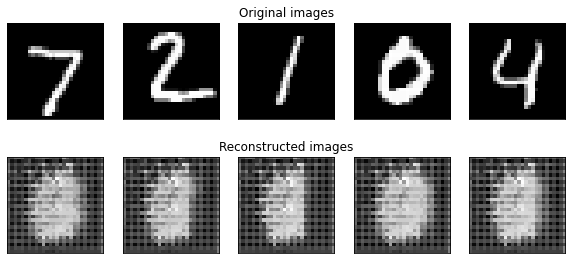

	 partial train loss (single batch): 19982.632812
	 partial train loss (single batch): 20050.966797
	 partial train loss (single batch): 19747.828125
	 partial train loss (single batch): 19833.292969
	 partial train loss (single batch): 19669.044922
	 partial train loss (single batch): 19438.539062
	 partial train loss (single batch): 19514.234375
	 partial train loss (single batch): 19462.666016
	 partial train loss (single batch): 19424.460938
	 partial train loss (single batch): 19151.214844
	 partial train loss (single batch): 19231.832031
	 partial train loss (single batch): 19234.572266
	 partial train loss (single batch): 19251.675781
	 partial train loss (single batch): 19194.839844
	 partial train loss (single batch): 18838.318359
	 partial train loss (single batch): 18976.521484
	 partial train loss (single batch): 18858.675781
	 partial train loss (single batch): 18877.654297
	 partial train loss (single batch): 18576.871094
	 partial train loss (single batch): 18817.570312


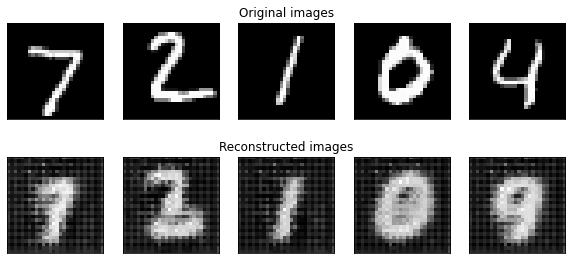

	 partial train loss (single batch): 13149.020508
	 partial train loss (single batch): 13322.724609
	 partial train loss (single batch): 13159.774414
	 partial train loss (single batch): 13328.861328
	 partial train loss (single batch): 13045.568359
	 partial train loss (single batch): 12811.412109
	 partial train loss (single batch): 12714.471680
	 partial train loss (single batch): 12883.091797
	 partial train loss (single batch): 13020.788086
	 partial train loss (single batch): 12733.736328
	 partial train loss (single batch): 12950.021484
	 partial train loss (single batch): 12933.137695
	 partial train loss (single batch): 13038.083984
	 partial train loss (single batch): 12975.699219
	 partial train loss (single batch): 12612.333984
	 partial train loss (single batch): 13089.119141
	 partial train loss (single batch): 12821.489258
	 partial train loss (single batch): 12976.561523
	 partial train loss (single batch): 12386.576172
	 partial train loss (single batch): 12907.779297


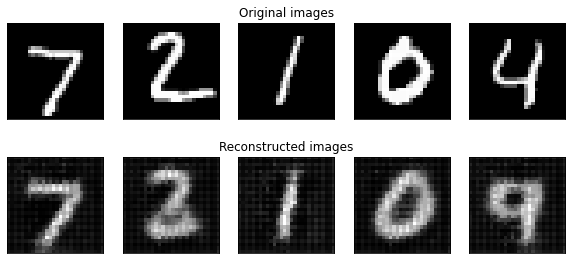

	 partial train loss (single batch): 11154.549805
	 partial train loss (single batch): 11377.133789
	 partial train loss (single batch): 11195.703125
	 partial train loss (single batch): 11271.194336
	 partial train loss (single batch): 10936.852539
	 partial train loss (single batch): 10867.430664
	 partial train loss (single batch): 10705.277344
	 partial train loss (single batch): 10955.477539
	 partial train loss (single batch): 11064.128906
	 partial train loss (single batch): 10847.817383
	 partial train loss (single batch): 10994.856445
	 partial train loss (single batch): 11176.574219
	 partial train loss (single batch): 11032.319336
	 partial train loss (single batch): 10976.928711
	 partial train loss (single batch): 10661.974609
	 partial train loss (single batch): 11095.658203
	 partial train loss (single batch): 10890.159180
	 partial train loss (single batch): 11045.813477
	 partial train loss (single batch): 10551.367188
	 partial train loss (single batch): 10931.163086


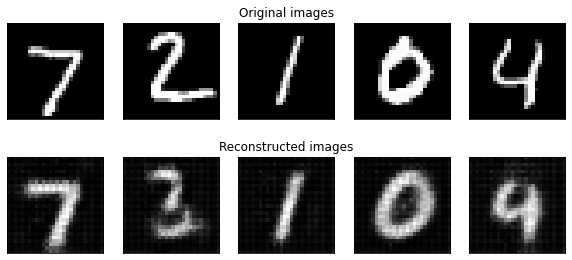

	 partial train loss (single batch): 9787.114258
	 partial train loss (single batch): 10122.076172
	 partial train loss (single batch): 9971.993164
	 partial train loss (single batch): 10074.824219
	 partial train loss (single batch): 9617.554688
	 partial train loss (single batch): 9597.802734
	 partial train loss (single batch): 9495.423828
	 partial train loss (single batch): 9768.925781
	 partial train loss (single batch): 9851.765625
	 partial train loss (single batch): 9800.746094
	 partial train loss (single batch): 9840.953125
	 partial train loss (single batch): 9966.864258
	 partial train loss (single batch): 9870.668945
	 partial train loss (single batch): 9841.488281
	 partial train loss (single batch): 9605.013672
	 partial train loss (single batch): 9898.766602
	 partial train loss (single batch): 9742.817383
	 partial train loss (single batch): 9958.525391
	 partial train loss (single batch): 9435.909180
	 partial train loss (single batch): 9825.911133
	 partial train lo

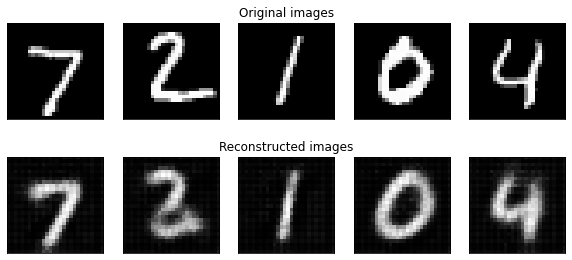

	 partial train loss (single batch): 9438.977539
	 partial train loss (single batch): 9719.004883
	 partial train loss (single batch): 9547.028320
	 partial train loss (single batch): 9647.666016
	 partial train loss (single batch): 9126.185547
	 partial train loss (single batch): 9208.100586
	 partial train loss (single batch): 9003.977539
	 partial train loss (single batch): 9238.720703
	 partial train loss (single batch): 9425.864258
	 partial train loss (single batch): 9295.048828
	 partial train loss (single batch): 9370.905273
	 partial train loss (single batch): 9510.105469
	 partial train loss (single batch): 9462.114258
	 partial train loss (single batch): 9504.160156
	 partial train loss (single batch): 9304.591797
	 partial train loss (single batch): 9606.308594
	 partial train loss (single batch): 9438.330078
	 partial train loss (single batch): 9514.028320
	 partial train loss (single batch): 8988.937500
	 partial train loss (single batch): 9424.000000
	 partial train loss

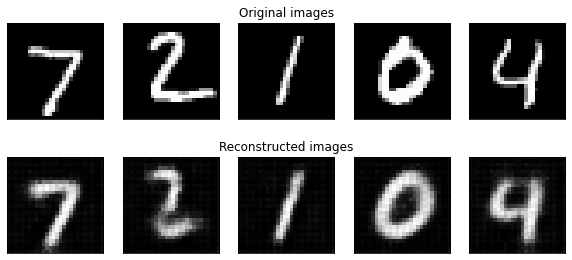

	 partial train loss (single batch): 9224.109375
	 partial train loss (single batch): 9452.392578
	 partial train loss (single batch): 9357.037109
	 partial train loss (single batch): 9470.042969
	 partial train loss (single batch): 8902.876953
	 partial train loss (single batch): 9008.004883
	 partial train loss (single batch): 8774.639648
	 partial train loss (single batch): 9050.187500
	 partial train loss (single batch): 9287.194336
	 partial train loss (single batch): 9116.995117
	 partial train loss (single batch): 9116.084961
	 partial train loss (single batch): 9304.416016
	 partial train loss (single batch): 9219.679688
	 partial train loss (single batch): 9215.997070
	 partial train loss (single batch): 9025.700195
	 partial train loss (single batch): 9297.228516
	 partial train loss (single batch): 9167.529297
	 partial train loss (single batch): 9430.980469
	 partial train loss (single batch): 8862.185547
	 partial train loss (single batch): 9109.047852
	 partial train loss

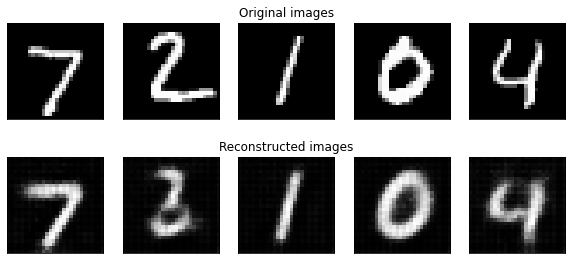

	 partial train loss (single batch): 9003.732422
	 partial train loss (single batch): 9261.878906
	 partial train loss (single batch): 9131.172852
	 partial train loss (single batch): 9302.069336
	 partial train loss (single batch): 8710.121094
	 partial train loss (single batch): 8852.004883
	 partial train loss (single batch): 8695.061523
	 partial train loss (single batch): 8815.083984
	 partial train loss (single batch): 9046.988281
	 partial train loss (single batch): 8999.689453
	 partial train loss (single batch): 9011.335938
	 partial train loss (single batch): 9039.771484
	 partial train loss (single batch): 9040.892578
	 partial train loss (single batch): 9027.331055
	 partial train loss (single batch): 8843.056641
	 partial train loss (single batch): 9127.925781
	 partial train loss (single batch): 9002.777344
	 partial train loss (single batch): 9206.984375
	 partial train loss (single batch): 8618.679688
	 partial train loss (single batch): 9007.190430
	 partial train loss

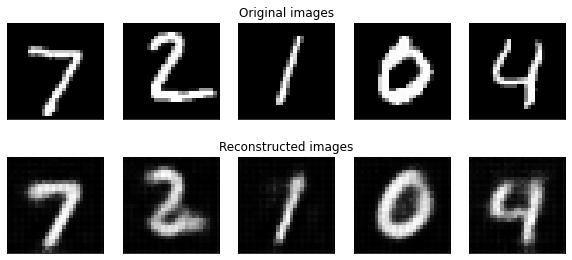

	 partial train loss (single batch): 8989.950195
	 partial train loss (single batch): 9192.998047
	 partial train loss (single batch): 9031.524414
	 partial train loss (single batch): 9278.685547
	 partial train loss (single batch): 8628.452148
	 partial train loss (single batch): 8807.550781
	 partial train loss (single batch): 8582.988281
	 partial train loss (single batch): 8780.539062
	 partial train loss (single batch): 8888.672852
	 partial train loss (single batch): 8860.501953
	 partial train loss (single batch): 8923.261719
	 partial train loss (single batch): 9038.287109
	 partial train loss (single batch): 8944.039062
	 partial train loss (single batch): 8945.233398
	 partial train loss (single batch): 8835.014648
	 partial train loss (single batch): 9151.135742
	 partial train loss (single batch): 8915.251953
	 partial train loss (single batch): 9165.879883
	 partial train loss (single batch): 8689.193359
	 partial train loss (single batch): 8934.378906
	 partial train loss

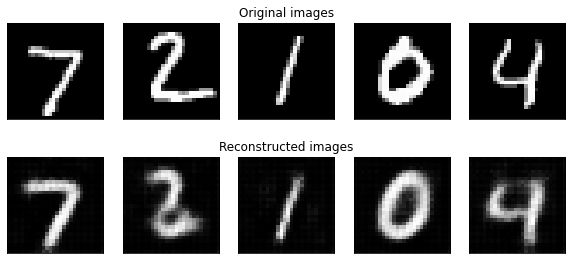

	 partial train loss (single batch): 8912.401367
	 partial train loss (single batch): 9137.250000
	 partial train loss (single batch): 8969.378906
	 partial train loss (single batch): 9097.154297
	 partial train loss (single batch): 8551.979492
	 partial train loss (single batch): 8708.336914
	 partial train loss (single batch): 8559.362305
	 partial train loss (single batch): 8665.419922
	 partial train loss (single batch): 8883.951172
	 partial train loss (single batch): 8812.121094
	 partial train loss (single batch): 8802.000977
	 partial train loss (single batch): 8938.484375
	 partial train loss (single batch): 8870.078125
	 partial train loss (single batch): 8810.666992
	 partial train loss (single batch): 8787.737305
	 partial train loss (single batch): 9014.392578
	 partial train loss (single batch): 8832.007812
	 partial train loss (single batch): 9014.142578
	 partial train loss (single batch): 8558.734375
	 partial train loss (single batch): 8775.554688
	 partial train loss

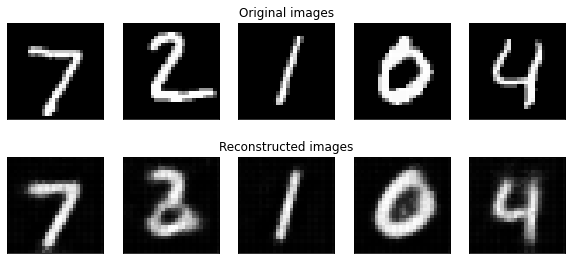

	 partial train loss (single batch): 8804.253906
	 partial train loss (single batch): 9018.273438
	 partial train loss (single batch): 8901.355469
	 partial train loss (single batch): 9038.171875
	 partial train loss (single batch): 8534.273438
	 partial train loss (single batch): 8678.092773
	 partial train loss (single batch): 8528.426758
	 partial train loss (single batch): 8672.565430
	 partial train loss (single batch): 8823.383789
	 partial train loss (single batch): 8721.656250
	 partial train loss (single batch): 8761.322266
	 partial train loss (single batch): 8951.893555
	 partial train loss (single batch): 8963.962891
	 partial train loss (single batch): 8787.751953
	 partial train loss (single batch): 8628.295898
	 partial train loss (single batch): 8947.152344
	 partial train loss (single batch): 8684.173828
	 partial train loss (single batch): 8995.017578
	 partial train loss (single batch): 8519.708984
	 partial train loss (single batch): 8668.062500
	 partial train loss

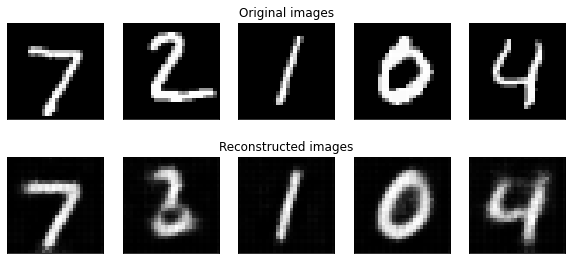

	 partial train loss (single batch): 8871.986328
	 partial train loss (single batch): 8997.783203
	 partial train loss (single batch): 8862.794922
	 partial train loss (single batch): 9055.964844
	 partial train loss (single batch): 8455.812500
	 partial train loss (single batch): 8644.816406
	 partial train loss (single batch): 8464.716797
	 partial train loss (single batch): 8584.564453
	 partial train loss (single batch): 8752.014648
	 partial train loss (single batch): 8662.121094
	 partial train loss (single batch): 8668.750000
	 partial train loss (single batch): 8869.007812
	 partial train loss (single batch): 8711.326172
	 partial train loss (single batch): 8791.609375
	 partial train loss (single batch): 8615.146484
	 partial train loss (single batch): 8843.588867
	 partial train loss (single batch): 8715.935547
	 partial train loss (single batch): 8990.250977
	 partial train loss (single batch): 8457.764648
	 partial train loss (single batch): 8751.652344
	 partial train loss

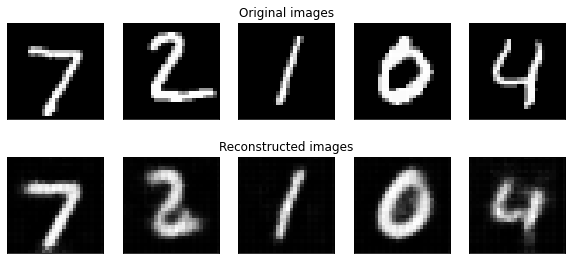

	 partial train loss (single batch): 8704.271484
	 partial train loss (single batch): 8922.772461
	 partial train loss (single batch): 8845.389648
	 partial train loss (single batch): 8944.990234
	 partial train loss (single batch): 8377.208984
	 partial train loss (single batch): 8583.240234
	 partial train loss (single batch): 8400.553711
	 partial train loss (single batch): 8533.773438
	 partial train loss (single batch): 8748.224609
	 partial train loss (single batch): 8613.173828
	 partial train loss (single batch): 8691.535156
	 partial train loss (single batch): 8865.445312
	 partial train loss (single batch): 8734.614258
	 partial train loss (single batch): 8662.725586
	 partial train loss (single batch): 8681.318359
	 partial train loss (single batch): 8813.425781
	 partial train loss (single batch): 8567.125977
	 partial train loss (single batch): 8839.526367
	 partial train loss (single batch): 8418.703125
	 partial train loss (single batch): 8704.301758
	 partial train loss

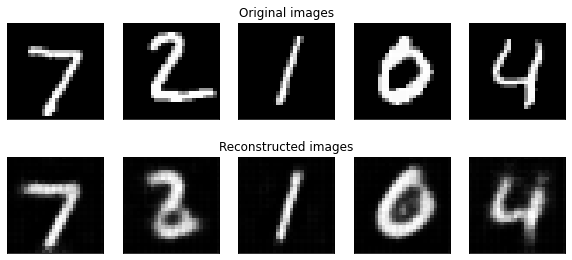

	 partial train loss (single batch): 8758.357422
	 partial train loss (single batch): 8933.529297
	 partial train loss (single batch): 8690.973633
	 partial train loss (single batch): 9047.200195
	 partial train loss (single batch): 8363.916992
	 partial train loss (single batch): 8505.134766
	 partial train loss (single batch): 8411.753906
	 partial train loss (single batch): 8481.877930
	 partial train loss (single batch): 8631.429688
	 partial train loss (single batch): 8557.281250
	 partial train loss (single batch): 8564.007812
	 partial train loss (single batch): 8828.806641
	 partial train loss (single batch): 8692.693359
	 partial train loss (single batch): 8668.026367
	 partial train loss (single batch): 8594.957031
	 partial train loss (single batch): 8877.061523
	 partial train loss (single batch): 8619.231445
	 partial train loss (single batch): 8852.574219
	 partial train loss (single batch): 8411.820312
	 partial train loss (single batch): 8666.836914
	 partial train loss

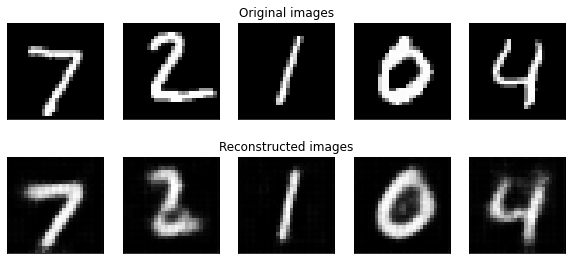

	 partial train loss (single batch): 8757.534180
	 partial train loss (single batch): 8824.679688
	 partial train loss (single batch): 8776.679688
	 partial train loss (single batch): 8984.142578
	 partial train loss (single batch): 8269.866211
	 partial train loss (single batch): 8447.304688
	 partial train loss (single batch): 8330.753906
	 partial train loss (single batch): 8490.766602
	 partial train loss (single batch): 8595.355469
	 partial train loss (single batch): 8605.191406
	 partial train loss (single batch): 8504.689453
	 partial train loss (single batch): 8778.503906
	 partial train loss (single batch): 8651.734375
	 partial train loss (single batch): 8574.791992
	 partial train loss (single batch): 8626.892578
	 partial train loss (single batch): 8808.272461
	 partial train loss (single batch): 8564.875000
	 partial train loss (single batch): 8783.595703
	 partial train loss (single batch): 8338.189453
	 partial train loss (single batch): 8584.371094
	 partial train loss

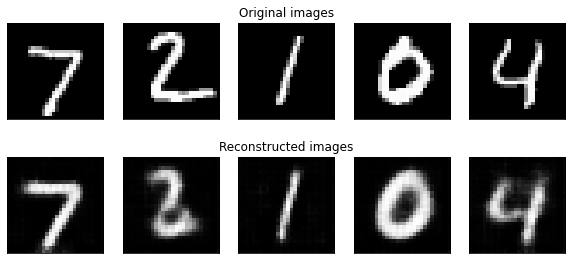

	 partial train loss (single batch): 8680.946289
	 partial train loss (single batch): 8854.914062
	 partial train loss (single batch): 8696.867188
	 partial train loss (single batch): 8859.032227
	 partial train loss (single batch): 8256.716797
	 partial train loss (single batch): 8423.875000
	 partial train loss (single batch): 8306.437500
	 partial train loss (single batch): 8380.865234
	 partial train loss (single batch): 8603.374023
	 partial train loss (single batch): 8495.736328
	 partial train loss (single batch): 8520.226562
	 partial train loss (single batch): 8791.797852
	 partial train loss (single batch): 8604.105469
	 partial train loss (single batch): 8589.734375
	 partial train loss (single batch): 8509.319336
	 partial train loss (single batch): 8688.611328
	 partial train loss (single batch): 8512.256836
	 partial train loss (single batch): 8810.789062
	 partial train loss (single batch): 8261.751953
	 partial train loss (single batch): 8508.571289
	 partial train loss

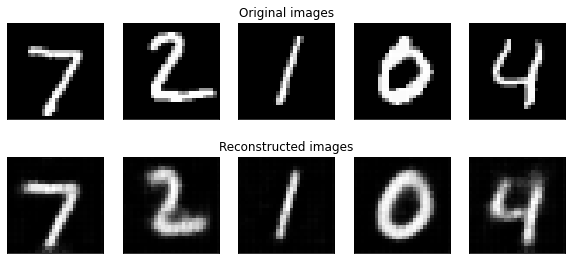

	 partial train loss (single batch): 8643.461914
	 partial train loss (single batch): 8810.193359
	 partial train loss (single batch): 8666.786133
	 partial train loss (single batch): 8775.323242
	 partial train loss (single batch): 8202.034180
	 partial train loss (single batch): 8436.401367
	 partial train loss (single batch): 8259.076172
	 partial train loss (single batch): 8427.063477
	 partial train loss (single batch): 8489.903320
	 partial train loss (single batch): 8448.033203
	 partial train loss (single batch): 8475.960938
	 partial train loss (single batch): 8707.033203
	 partial train loss (single batch): 8563.396484
	 partial train loss (single batch): 8517.005859
	 partial train loss (single batch): 8482.101562
	 partial train loss (single batch): 8643.421875
	 partial train loss (single batch): 8499.881836
	 partial train loss (single batch): 8706.786133
	 partial train loss (single batch): 8244.044922
	 partial train loss (single batch): 8592.712891
	 partial train loss

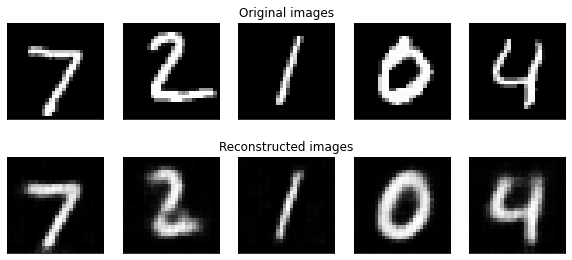

	 partial train loss (single batch): 8577.526367
	 partial train loss (single batch): 8786.255859
	 partial train loss (single batch): 8676.425781
	 partial train loss (single batch): 8834.224609
	 partial train loss (single batch): 8135.933594
	 partial train loss (single batch): 8380.042969
	 partial train loss (single batch): 8279.922852
	 partial train loss (single batch): 8395.393555
	 partial train loss (single batch): 8538.574219
	 partial train loss (single batch): 8530.547852
	 partial train loss (single batch): 8423.552734
	 partial train loss (single batch): 8631.693359
	 partial train loss (single batch): 8494.794922
	 partial train loss (single batch): 8638.873047
	 partial train loss (single batch): 8629.756836
	 partial train loss (single batch): 8648.409180
	 partial train loss (single batch): 8465.246094
	 partial train loss (single batch): 8739.667969
	 partial train loss (single batch): 8311.863281
	 partial train loss (single batch): 8552.793945
	 partial train loss

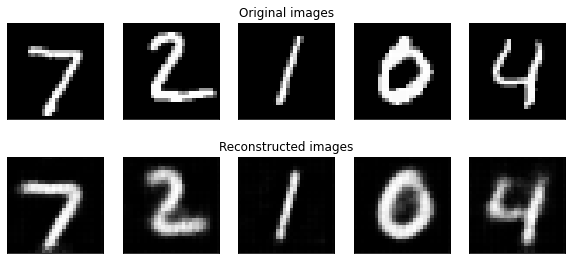

	 partial train loss (single batch): 8660.988281
	 partial train loss (single batch): 8765.964844
	 partial train loss (single batch): 8646.451172
	 partial train loss (single batch): 8794.299805
	 partial train loss (single batch): 8205.159180
	 partial train loss (single batch): 8399.087891
	 partial train loss (single batch): 8274.615234
	 partial train loss (single batch): 8384.117188
	 partial train loss (single batch): 8503.478516
	 partial train loss (single batch): 8483.994141
	 partial train loss (single batch): 8494.966797
	 partial train loss (single batch): 8684.182617
	 partial train loss (single batch): 8534.643555
	 partial train loss (single batch): 8535.242188
	 partial train loss (single batch): 8466.914062
	 partial train loss (single batch): 8576.039062
	 partial train loss (single batch): 8429.445312
	 partial train loss (single batch): 8717.212891
	 partial train loss (single batch): 8196.553711
	 partial train loss (single batch): 8565.782227
	 partial train loss

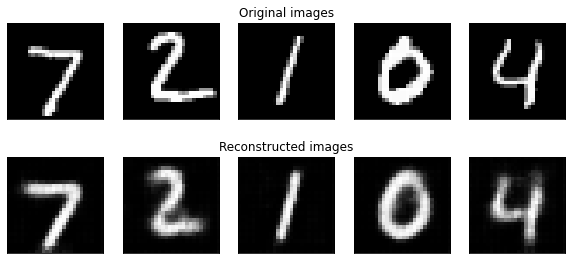

	 partial train loss (single batch): 8614.734375
	 partial train loss (single batch): 8718.366211
	 partial train loss (single batch): 8565.007812
	 partial train loss (single batch): 8772.995117
	 partial train loss (single batch): 8122.696777
	 partial train loss (single batch): 8413.729492
	 partial train loss (single batch): 8192.728516
	 partial train loss (single batch): 8341.809570
	 partial train loss (single batch): 8461.337891
	 partial train loss (single batch): 8338.879883
	 partial train loss (single batch): 8466.322266
	 partial train loss (single batch): 8642.289062
	 partial train loss (single batch): 8469.540039
	 partial train loss (single batch): 8514.240234
	 partial train loss (single batch): 8492.948242
	 partial train loss (single batch): 8520.081055
	 partial train loss (single batch): 8396.718750
	 partial train loss (single batch): 8687.294922
	 partial train loss (single batch): 8233.011719
	 partial train loss (single batch): 8482.234375
	 partial train loss

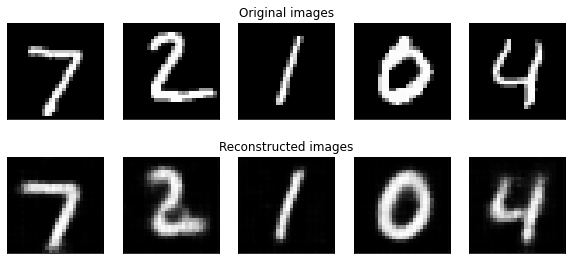

	 partial train loss (single batch): 8631.122070
	 partial train loss (single batch): 8727.677734
	 partial train loss (single batch): 8578.725586
	 partial train loss (single batch): 8731.462891
	 partial train loss (single batch): 8115.464844
	 partial train loss (single batch): 8306.230469
	 partial train loss (single batch): 8218.015625
	 partial train loss (single batch): 8283.434570
	 partial train loss (single batch): 8484.875000
	 partial train loss (single batch): 8381.113281
	 partial train loss (single batch): 8438.060547
	 partial train loss (single batch): 8591.193359
	 partial train loss (single batch): 8518.080078
	 partial train loss (single batch): 8585.285156
	 partial train loss (single batch): 8591.279297
	 partial train loss (single batch): 8567.603516
	 partial train loss (single batch): 8421.101562
	 partial train loss (single batch): 8719.216797
	 partial train loss (single batch): 8228.620117
	 partial train loss (single batch): 8425.567383
	 partial train loss

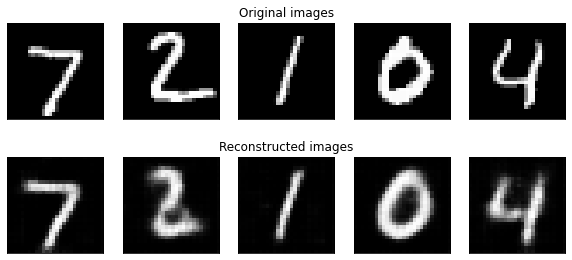

	 partial train loss (single batch): 8634.049805
	 partial train loss (single batch): 8738.374023
	 partial train loss (single batch): 8554.382812
	 partial train loss (single batch): 8702.199219
	 partial train loss (single batch): 8110.006836
	 partial train loss (single batch): 8395.855469
	 partial train loss (single batch): 8182.253418
	 partial train loss (single batch): 8273.742188
	 partial train loss (single batch): 8384.692383
	 partial train loss (single batch): 8371.386719
	 partial train loss (single batch): 8419.353516
	 partial train loss (single batch): 8631.543945
	 partial train loss (single batch): 8460.964844
	 partial train loss (single batch): 8432.744141
	 partial train loss (single batch): 8483.763672
	 partial train loss (single batch): 8490.172852
	 partial train loss (single batch): 8382.126953
	 partial train loss (single batch): 8681.543945
	 partial train loss (single batch): 8118.573242
	 partial train loss (single batch): 8481.933594
	 partial train loss

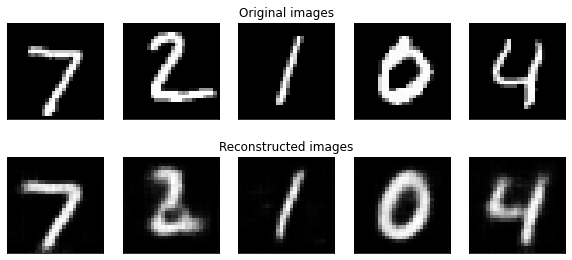

	 partial train loss (single batch): 8533.553711
	 partial train loss (single batch): 8667.667969
	 partial train loss (single batch): 8571.384766
	 partial train loss (single batch): 8740.253906
	 partial train loss (single batch): 8093.891602
	 partial train loss (single batch): 8312.980469
	 partial train loss (single batch): 8123.341309
	 partial train loss (single batch): 8292.424805
	 partial train loss (single batch): 8455.685547
	 partial train loss (single batch): 8392.605469
	 partial train loss (single batch): 8413.710938
	 partial train loss (single batch): 8611.449219
	 partial train loss (single batch): 8405.994141
	 partial train loss (single batch): 8456.384766
	 partial train loss (single batch): 8431.412109
	 partial train loss (single batch): 8476.404297
	 partial train loss (single batch): 8347.419922
	 partial train loss (single batch): 8589.786133
	 partial train loss (single batch): 8109.594727
	 partial train loss (single batch): 8378.480469
	 partial train loss

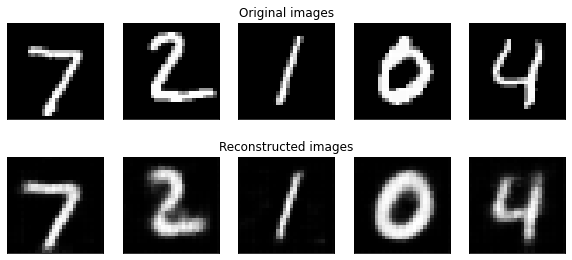

	 partial train loss (single batch): 8501.861328
	 partial train loss (single batch): 8652.145508
	 partial train loss (single batch): 8480.891602
	 partial train loss (single batch): 8660.010742
	 partial train loss (single batch): 8014.891602
	 partial train loss (single batch): 8220.787109
	 partial train loss (single batch): 8137.236328
	 partial train loss (single batch): 8193.224609
	 partial train loss (single batch): 8391.539062
	 partial train loss (single batch): 8333.544922
	 partial train loss (single batch): 8344.785156
	 partial train loss (single batch): 8504.013672
	 partial train loss (single batch): 8443.529297
	 partial train loss (single batch): 8420.107422
	 partial train loss (single batch): 8379.033203
	 partial train loss (single batch): 8505.726562
	 partial train loss (single batch): 8410.345703
	 partial train loss (single batch): 8764.725586
	 partial train loss (single batch): 8105.399414
	 partial train loss (single batch): 8428.208008
	 partial train loss

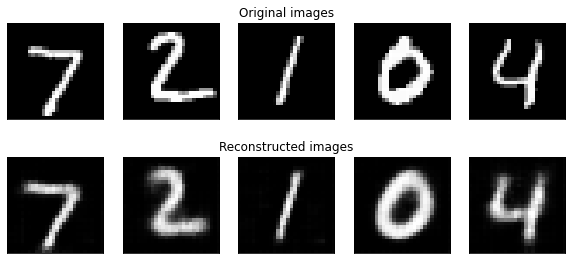

	 partial train loss (single batch): 8534.779297
	 partial train loss (single batch): 8639.829102
	 partial train loss (single batch): 8421.710938
	 partial train loss (single batch): 8673.832031
	 partial train loss (single batch): 8075.845703
	 partial train loss (single batch): 8288.237305
	 partial train loss (single batch): 8135.461914
	 partial train loss (single batch): 8225.898438
	 partial train loss (single batch): 8411.623047
	 partial train loss (single batch): 8313.455078
	 partial train loss (single batch): 8363.511719
	 partial train loss (single batch): 8575.818359
	 partial train loss (single batch): 8423.797852
	 partial train loss (single batch): 8437.048828
	 partial train loss (single batch): 8340.050781
	 partial train loss (single batch): 8456.763672
	 partial train loss (single batch): 8290.344727
	 partial train loss (single batch): 8612.670898
	 partial train loss (single batch): 8143.416016
	 partial train loss (single batch): 8328.561523
	 partial train loss

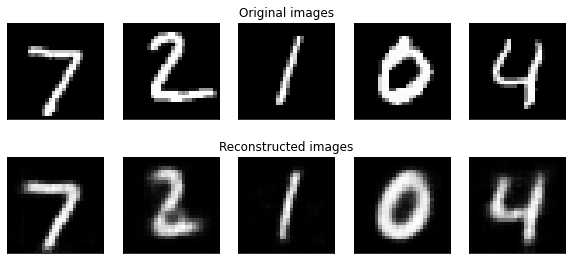

	 partial train loss (single batch): 8449.420898
	 partial train loss (single batch): 8567.535156
	 partial train loss (single batch): 8481.246094
	 partial train loss (single batch): 8654.935547
	 partial train loss (single batch): 8092.173828
	 partial train loss (single batch): 8298.504883
	 partial train loss (single batch): 8121.606934
	 partial train loss (single batch): 8215.160156
	 partial train loss (single batch): 8416.005859
	 partial train loss (single batch): 8260.720703
	 partial train loss (single batch): 8352.867188
	 partial train loss (single batch): 8541.921875
	 partial train loss (single batch): 8392.794922
	 partial train loss (single batch): 8401.397461
	 partial train loss (single batch): 8364.656250
	 partial train loss (single batch): 8483.178711
	 partial train loss (single batch): 8338.591797
	 partial train loss (single batch): 8628.967773
	 partial train loss (single batch): 8096.321289
	 partial train loss (single batch): 8320.265625
	 partial train loss

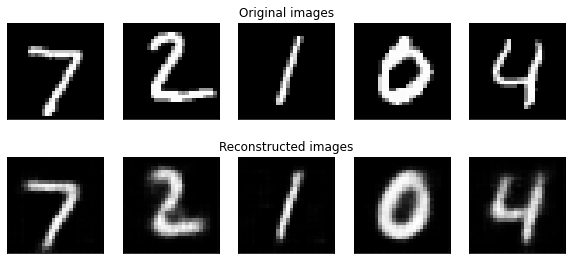

	 partial train loss (single batch): 8460.032227
	 partial train loss (single batch): 8580.986328
	 partial train loss (single batch): 8523.185547
	 partial train loss (single batch): 8691.869141
	 partial train loss (single batch): 8038.185059
	 partial train loss (single batch): 8245.869141
	 partial train loss (single batch): 8089.097656
	 partial train loss (single batch): 8243.887695
	 partial train loss (single batch): 8282.814453
	 partial train loss (single batch): 8311.959961
	 partial train loss (single batch): 8324.056641
	 partial train loss (single batch): 8560.985352
	 partial train loss (single batch): 8372.517578
	 partial train loss (single batch): 8403.500977
	 partial train loss (single batch): 8430.895508
	 partial train loss (single batch): 8429.956055
	 partial train loss (single batch): 8324.299805
	 partial train loss (single batch): 8575.050781
	 partial train loss (single batch): 8110.800781
	 partial train loss (single batch): 8304.275391
	 partial train loss

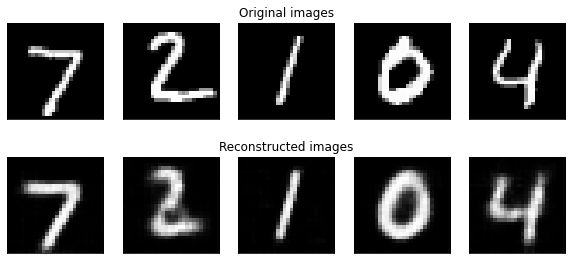

	 partial train loss (single batch): 8340.817383
	 partial train loss (single batch): 8633.035156
	 partial train loss (single batch): 8479.777344
	 partial train loss (single batch): 8624.281250
	 partial train loss (single batch): 7984.809570
	 partial train loss (single batch): 8237.922852
	 partial train loss (single batch): 8112.008789
	 partial train loss (single batch): 8236.480469
	 partial train loss (single batch): 8308.834961
	 partial train loss (single batch): 8255.820312
	 partial train loss (single batch): 8312.295898
	 partial train loss (single batch): 8497.228516
	 partial train loss (single batch): 8320.177734
	 partial train loss (single batch): 8326.590820
	 partial train loss (single batch): 8317.976562
	 partial train loss (single batch): 8388.826172
	 partial train loss (single batch): 8312.085938
	 partial train loss (single batch): 8588.524414
	 partial train loss (single batch): 8108.965820
	 partial train loss (single batch): 8242.294922
	 partial train loss

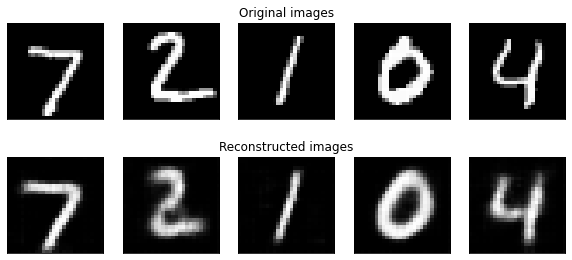

	 partial train loss (single batch): 8443.367188
	 partial train loss (single batch): 8630.444336
	 partial train loss (single batch): 8437.094727
	 partial train loss (single batch): 8580.580078
	 partial train loss (single batch): 8049.990234
	 partial train loss (single batch): 8198.842773
	 partial train loss (single batch): 8118.316406
	 partial train loss (single batch): 8206.419922
	 partial train loss (single batch): 8321.711914
	 partial train loss (single batch): 8294.006836
	 partial train loss (single batch): 8297.262695
	 partial train loss (single batch): 8549.281250
	 partial train loss (single batch): 8306.212891
	 partial train loss (single batch): 8387.521484
	 partial train loss (single batch): 8368.607422
	 partial train loss (single batch): 8423.537109
	 partial train loss (single batch): 8391.012695
	 partial train loss (single batch): 8545.857422
	 partial train loss (single batch): 8139.371094
	 partial train loss (single batch): 8347.462891
	 partial train loss

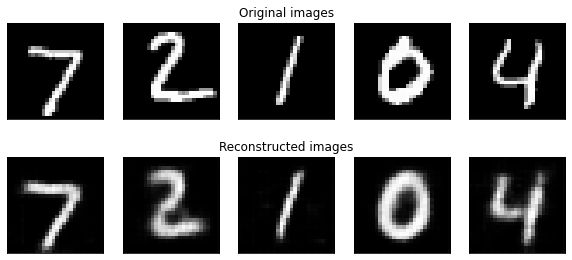

	 partial train loss (single batch): 8394.468750
	 partial train loss (single batch): 8628.669922
	 partial train loss (single batch): 8423.832031
	 partial train loss (single batch): 8609.785156
	 partial train loss (single batch): 7980.489258
	 partial train loss (single batch): 8198.000000
	 partial train loss (single batch): 8021.230469
	 partial train loss (single batch): 8211.758789
	 partial train loss (single batch): 8354.941406
	 partial train loss (single batch): 8253.585938
	 partial train loss (single batch): 8299.288086
	 partial train loss (single batch): 8427.208984
	 partial train loss (single batch): 8345.304688
	 partial train loss (single batch): 8326.903320
	 partial train loss (single batch): 8367.718750
	 partial train loss (single batch): 8385.683594
	 partial train loss (single batch): 8328.786133
	 partial train loss (single batch): 8600.005859
	 partial train loss (single batch): 8063.359375
	 partial train loss (single batch): 8304.312500
	 partial train loss

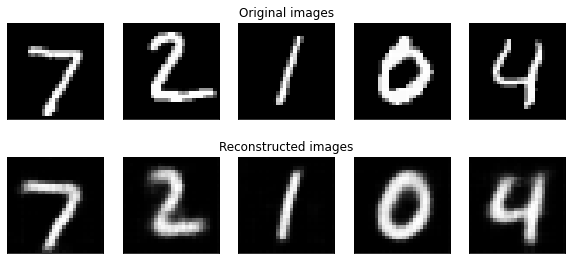

	 partial train loss (single batch): 8438.673828
	 partial train loss (single batch): 8622.730469
	 partial train loss (single batch): 8355.725586
	 partial train loss (single batch): 8558.864258
	 partial train loss (single batch): 7940.841309
	 partial train loss (single batch): 8258.009766
	 partial train loss (single batch): 8077.836914
	 partial train loss (single batch): 8240.386719
	 partial train loss (single batch): 8363.735352
	 partial train loss (single batch): 8283.891602
	 partial train loss (single batch): 8359.940430
	 partial train loss (single batch): 8519.242188
	 partial train loss (single batch): 8348.213867
	 partial train loss (single batch): 8352.865234
	 partial train loss (single batch): 8268.346680
	 partial train loss (single batch): 8325.048828
	 partial train loss (single batch): 8282.112305
	 partial train loss (single batch): 8624.333984
	 partial train loss (single batch): 8041.090820
	 partial train loss (single batch): 8177.803711
	 partial train loss

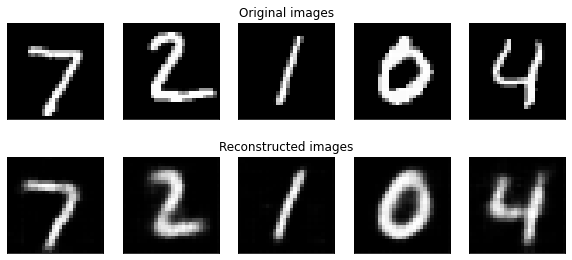

	 partial train loss (single batch): 8426.525391
	 partial train loss (single batch): 8662.567383
	 partial train loss (single batch): 8417.298828
	 partial train loss (single batch): 8641.403320
	 partial train loss (single batch): 7987.085938
	 partial train loss (single batch): 8176.042480
	 partial train loss (single batch): 8074.095215
	 partial train loss (single batch): 8157.144043
	 partial train loss (single batch): 8357.492188
	 partial train loss (single batch): 8302.585938
	 partial train loss (single batch): 8223.757812
	 partial train loss (single batch): 8466.506836
	 partial train loss (single batch): 8378.634766
	 partial train loss (single batch): 8268.218750
	 partial train loss (single batch): 8327.386719
	 partial train loss (single batch): 8370.586914
	 partial train loss (single batch): 8217.616211
	 partial train loss (single batch): 8569.855469
	 partial train loss (single batch): 8095.589355
	 partial train loss (single batch): 8245.972656
	 partial train loss

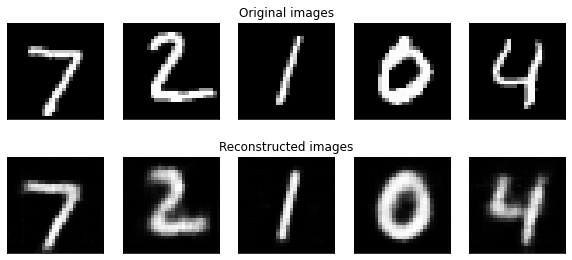

	 partial train loss (single batch): 8449.458984
	 partial train loss (single batch): 8667.036133
	 partial train loss (single batch): 8357.471680
	 partial train loss (single batch): 8570.576172
	 partial train loss (single batch): 7941.539062
	 partial train loss (single batch): 8172.598633
	 partial train loss (single batch): 8039.921875
	 partial train loss (single batch): 8146.363281
	 partial train loss (single batch): 8382.732422
	 partial train loss (single batch): 8185.819824
	 partial train loss (single batch): 8269.266602
	 partial train loss (single batch): 8423.853516
	 partial train loss (single batch): 8314.398438
	 partial train loss (single batch): 8346.953125
	 partial train loss (single batch): 8437.240234
	 partial train loss (single batch): 8372.748047
	 partial train loss (single batch): 8228.588867
	 partial train loss (single batch): 8534.065430
	 partial train loss (single batch): 8009.638672
	 partial train loss (single batch): 8241.361328
	 partial train loss

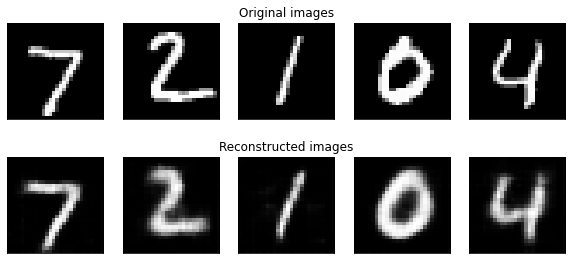

	 partial train loss (single batch): 8420.886719
	 partial train loss (single batch): 8579.856445
	 partial train loss (single batch): 8347.231445
	 partial train loss (single batch): 8527.760742
	 partial train loss (single batch): 7957.156250
	 partial train loss (single batch): 8210.028320
	 partial train loss (single batch): 8058.426270
	 partial train loss (single batch): 8119.927734
	 partial train loss (single batch): 8304.490234
	 partial train loss (single batch): 8299.895508
	 partial train loss (single batch): 8253.801758
	 partial train loss (single batch): 8457.041016
	 partial train loss (single batch): 8315.648438
	 partial train loss (single batch): 8318.240234
	 partial train loss (single batch): 8239.691406
	 partial train loss (single batch): 8350.703125
	 partial train loss (single batch): 8252.531250
	 partial train loss (single batch): 8522.461914
	 partial train loss (single batch): 8056.079102
	 partial train loss (single batch): 8298.779297
	 partial train loss

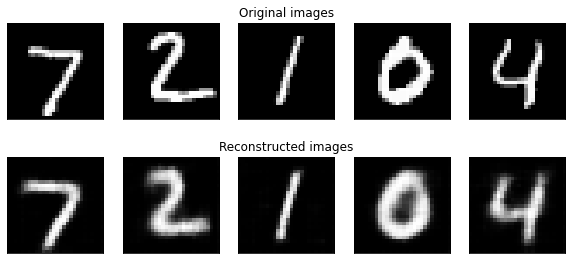

	 partial train loss (single batch): 8357.340820
	 partial train loss (single batch): 8578.198242
	 partial train loss (single batch): 8330.625977
	 partial train loss (single batch): 8551.631836
	 partial train loss (single batch): 7880.347656
	 partial train loss (single batch): 8165.467285
	 partial train loss (single batch): 8041.653320
	 partial train loss (single batch): 8168.169434
	 partial train loss (single batch): 8249.464844
	 partial train loss (single batch): 8186.547852
	 partial train loss (single batch): 8249.792969
	 partial train loss (single batch): 8433.046875
	 partial train loss (single batch): 8326.181641
	 partial train loss (single batch): 8304.227539
	 partial train loss (single batch): 8256.977539
	 partial train loss (single batch): 8332.332031
	 partial train loss (single batch): 8274.363281
	 partial train loss (single batch): 8462.823242
	 partial train loss (single batch): 8027.036133
	 partial train loss (single batch): 8242.589844
	 partial train loss

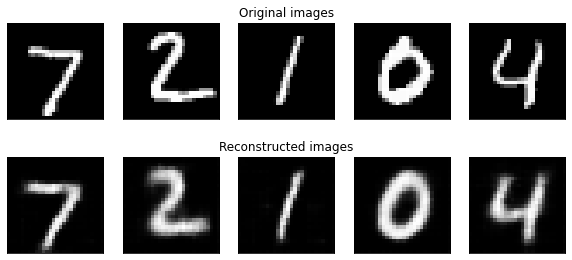

	 partial train loss (single batch): 8469.449219
	 partial train loss (single batch): 8464.449219
	 partial train loss (single batch): 8280.154297
	 partial train loss (single batch): 8545.298828
	 partial train loss (single batch): 7945.813965
	 partial train loss (single batch): 8116.960938
	 partial train loss (single batch): 8012.366699
	 partial train loss (single batch): 8149.101562
	 partial train loss (single batch): 8222.302734
	 partial train loss (single batch): 8185.461426
	 partial train loss (single batch): 8239.724609
	 partial train loss (single batch): 8452.679688
	 partial train loss (single batch): 8327.990234
	 partial train loss (single batch): 8241.588867
	 partial train loss (single batch): 8269.406250
	 partial train loss (single batch): 8311.435547
	 partial train loss (single batch): 8187.045898
	 partial train loss (single batch): 8506.341797
	 partial train loss (single batch): 8047.238281
	 partial train loss (single batch): 8238.211914
	 partial train loss

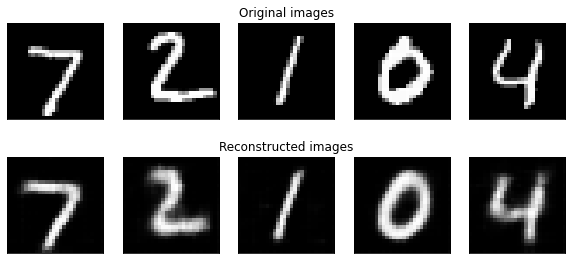

	 partial train loss (single batch): 8382.854492
	 partial train loss (single batch): 8539.384766
	 partial train loss (single batch): 8413.541016
	 partial train loss (single batch): 8512.314453
	 partial train loss (single batch): 7878.542969
	 partial train loss (single batch): 8193.289062
	 partial train loss (single batch): 8041.066406
	 partial train loss (single batch): 8142.281738
	 partial train loss (single batch): 8290.686523
	 partial train loss (single batch): 8229.177734
	 partial train loss (single batch): 8251.025391
	 partial train loss (single batch): 8386.861328
	 partial train loss (single batch): 8263.369141
	 partial train loss (single batch): 8209.728516
	 partial train loss (single batch): 8246.483398
	 partial train loss (single batch): 8354.385742
	 partial train loss (single batch): 8164.894043
	 partial train loss (single batch): 8461.137695
	 partial train loss (single batch): 7995.613281
	 partial train loss (single batch): 8219.908203
	 partial train loss

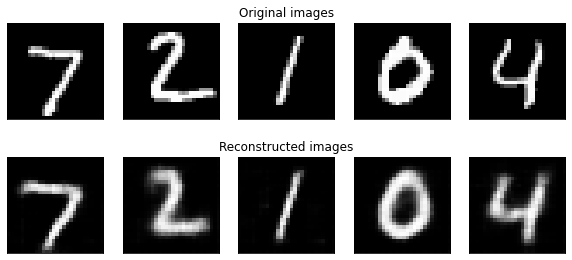

	 partial train loss (single batch): 8387.201172
	 partial train loss (single batch): 8520.717773
	 partial train loss (single batch): 8310.992188
	 partial train loss (single batch): 8538.893555
	 partial train loss (single batch): 7908.798340
	 partial train loss (single batch): 8164.892578
	 partial train loss (single batch): 7990.168945
	 partial train loss (single batch): 8107.036133
	 partial train loss (single batch): 8240.156250
	 partial train loss (single batch): 8212.038086
	 partial train loss (single batch): 8249.995117
	 partial train loss (single batch): 8399.994141
	 partial train loss (single batch): 8348.311523
	 partial train loss (single batch): 8270.119141
	 partial train loss (single batch): 8283.375000
	 partial train loss (single batch): 8317.702148
	 partial train loss (single batch): 8195.685547
	 partial train loss (single batch): 8432.085938
	 partial train loss (single batch): 8041.991211
	 partial train loss (single batch): 8150.253418
	 partial train loss

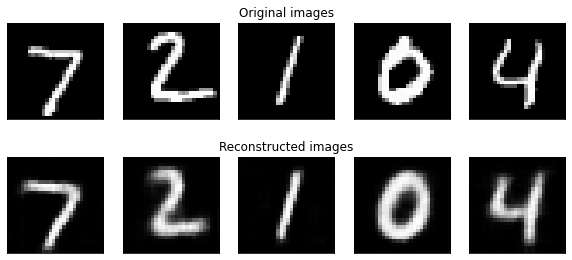

	 partial train loss (single batch): 8327.818359
	 partial train loss (single batch): 8461.287109
	 partial train loss (single batch): 8354.208984
	 partial train loss (single batch): 8512.527344
	 partial train loss (single batch): 7838.170410
	 partial train loss (single batch): 8143.520996
	 partial train loss (single batch): 8047.979492
	 partial train loss (single batch): 8146.598633
	 partial train loss (single batch): 8284.751953
	 partial train loss (single batch): 8193.720703
	 partial train loss (single batch): 8147.394531
	 partial train loss (single batch): 8418.635742
	 partial train loss (single batch): 8229.957031
	 partial train loss (single batch): 8358.821289
	 partial train loss (single batch): 8280.485352
	 partial train loss (single batch): 8266.502930
	 partial train loss (single batch): 8244.791016
	 partial train loss (single batch): 8609.255859
	 partial train loss (single batch): 8028.381348
	 partial train loss (single batch): 8216.558594
	 partial train loss

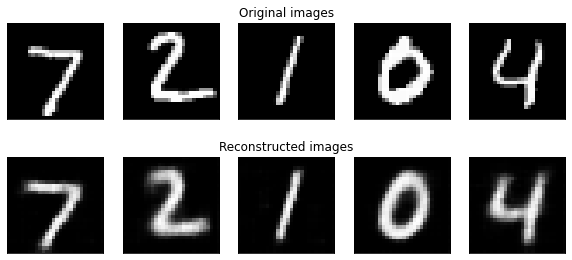

	 partial train loss (single batch): 8263.114258
	 partial train loss (single batch): 8515.219727
	 partial train loss (single batch): 8240.701172
	 partial train loss (single batch): 8516.250000
	 partial train loss (single batch): 7935.094727
	 partial train loss (single batch): 8076.854492
	 partial train loss (single batch): 7991.317871
	 partial train loss (single batch): 8137.488281
	 partial train loss (single batch): 8244.947266
	 partial train loss (single batch): 8213.788086
	 partial train loss (single batch): 8180.541504
	 partial train loss (single batch): 8384.090820
	 partial train loss (single batch): 8213.525391
	 partial train loss (single batch): 8230.917969
	 partial train loss (single batch): 8217.529297
	 partial train loss (single batch): 8241.755859
	 partial train loss (single batch): 8086.756836
	 partial train loss (single batch): 8472.861328
	 partial train loss (single batch): 8046.255859
	 partial train loss (single batch): 8182.247070
	 partial train loss

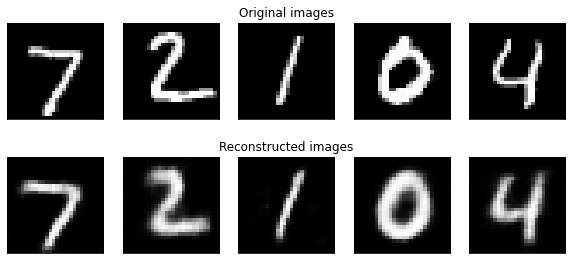

	 partial train loss (single batch): 8263.777344
	 partial train loss (single batch): 8501.416016
	 partial train loss (single batch): 8304.487305
	 partial train loss (single batch): 8520.987305
	 partial train loss (single batch): 7995.687500
	 partial train loss (single batch): 8128.391602
	 partial train loss (single batch): 7989.214844
	 partial train loss (single batch): 8032.947754
	 partial train loss (single batch): 8323.939453
	 partial train loss (single batch): 8205.811523
	 partial train loss (single batch): 8161.067383
	 partial train loss (single batch): 8347.943359
	 partial train loss (single batch): 8173.292480
	 partial train loss (single batch): 8193.571289
	 partial train loss (single batch): 8289.880859
	 partial train loss (single batch): 8259.442383
	 partial train loss (single batch): 8154.701660
	 partial train loss (single batch): 8393.142578
	 partial train loss (single batch): 7962.497070
	 partial train loss (single batch): 8196.336914
	 partial train loss

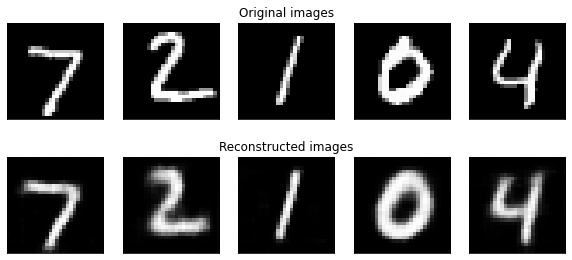

	 partial train loss (single batch): 8308.123047
	 partial train loss (single batch): 8470.933594
	 partial train loss (single batch): 8250.758789
	 partial train loss (single batch): 8436.567383
	 partial train loss (single batch): 7877.028809
	 partial train loss (single batch): 8137.488770
	 partial train loss (single batch): 7950.863770
	 partial train loss (single batch): 8030.416016
	 partial train loss (single batch): 8238.658203
	 partial train loss (single batch): 8202.578125
	 partial train loss (single batch): 8196.734375
	 partial train loss (single batch): 8397.050781
	 partial train loss (single batch): 8233.498047
	 partial train loss (single batch): 8197.649414
	 partial train loss (single batch): 8240.608398
	 partial train loss (single batch): 8301.824219
	 partial train loss (single batch): 8201.123047
	 partial train loss (single batch): 8473.406250
	 partial train loss (single batch): 7994.540039
	 partial train loss (single batch): 8194.117188
	 partial train loss

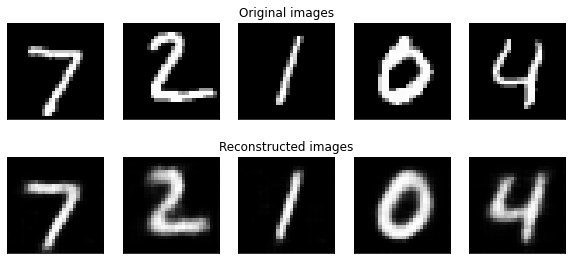

	 partial train loss (single batch): 8301.123047
	 partial train loss (single batch): 8458.994141
	 partial train loss (single batch): 8323.083008
	 partial train loss (single batch): 8539.817383
	 partial train loss (single batch): 7874.410156
	 partial train loss (single batch): 8053.559082
	 partial train loss (single batch): 7983.885742
	 partial train loss (single batch): 8076.163086
	 partial train loss (single batch): 8124.719727
	 partial train loss (single batch): 8157.680176
	 partial train loss (single batch): 8156.571289
	 partial train loss (single batch): 8371.251953
	 partial train loss (single batch): 8275.298828
	 partial train loss (single batch): 8175.997070
	 partial train loss (single batch): 8167.409668
	 partial train loss (single batch): 8313.683594
	 partial train loss (single batch): 8174.558594
	 partial train loss (single batch): 8440.325195
	 partial train loss (single batch): 7951.017578
	 partial train loss (single batch): 8200.060547
	 partial train loss

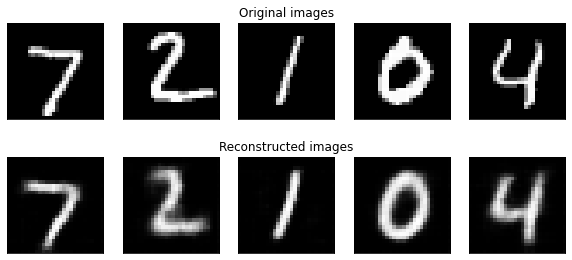

	 partial train loss (single batch): 8294.849609
	 partial train loss (single batch): 8485.985352
	 partial train loss (single batch): 8273.602539
	 partial train loss (single batch): 8588.127930
	 partial train loss (single batch): 7835.115723
	 partial train loss (single batch): 8032.194824
	 partial train loss (single batch): 7979.317871
	 partial train loss (single batch): 8108.504883
	 partial train loss (single batch): 8208.897461
	 partial train loss (single batch): 8124.856934
	 partial train loss (single batch): 8102.383789
	 partial train loss (single batch): 8331.748047
	 partial train loss (single batch): 8283.065430
	 partial train loss (single batch): 8222.808594
	 partial train loss (single batch): 8249.244141
	 partial train loss (single batch): 8282.963867
	 partial train loss (single batch): 8178.375977
	 partial train loss (single batch): 8406.302734
	 partial train loss (single batch): 8066.440430
	 partial train loss (single batch): 8210.542969
	 partial train loss

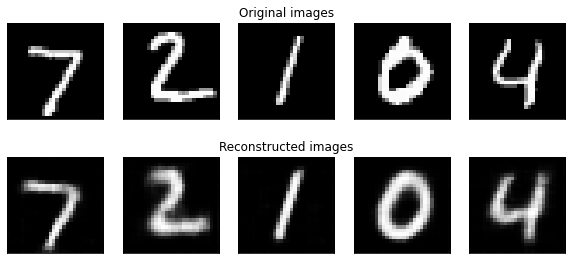

	 partial train loss (single batch): 8415.918945
	 partial train loss (single batch): 8482.046875
	 partial train loss (single batch): 8267.493164
	 partial train loss (single batch): 8468.550781
	 partial train loss (single batch): 7916.051270
	 partial train loss (single batch): 8144.960938
	 partial train loss (single batch): 7958.835449
	 partial train loss (single batch): 8082.412598
	 partial train loss (single batch): 8225.106445
	 partial train loss (single batch): 8116.657715
	 partial train loss (single batch): 8111.292969
	 partial train loss (single batch): 8296.627930
	 partial train loss (single batch): 8225.668945
	 partial train loss (single batch): 8237.757812
	 partial train loss (single batch): 8253.071289
	 partial train loss (single batch): 8210.506836
	 partial train loss (single batch): 8113.856934
	 partial train loss (single batch): 8545.997070
	 partial train loss (single batch): 7976.293457
	 partial train loss (single batch): 8175.851562
	 partial train loss

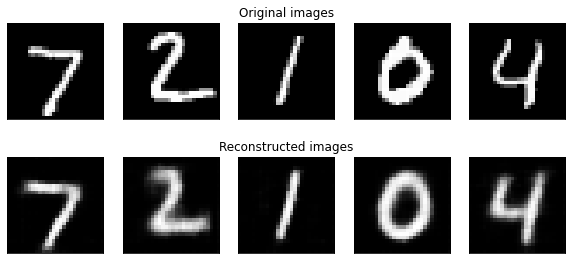

	 partial train loss (single batch): 8269.338867
	 partial train loss (single batch): 8431.021484
	 partial train loss (single batch): 8331.231445
	 partial train loss (single batch): 8471.348633
	 partial train loss (single batch): 7756.185547
	 partial train loss (single batch): 8104.989746
	 partial train loss (single batch): 7970.012695
	 partial train loss (single batch): 8004.035156
	 partial train loss (single batch): 8233.092773
	 partial train loss (single batch): 8070.256836
	 partial train loss (single batch): 8203.662109
	 partial train loss (single batch): 8341.107422
	 partial train loss (single batch): 8243.535156
	 partial train loss (single batch): 8166.012695
	 partial train loss (single batch): 8217.926758
	 partial train loss (single batch): 8225.082031
	 partial train loss (single batch): 8143.178711
	 partial train loss (single batch): 8358.830078
	 partial train loss (single batch): 7968.669922
	 partial train loss (single batch): 8187.381348
	 partial train loss

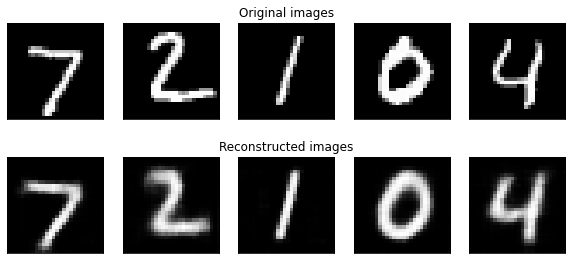

	 partial train loss (single batch): 8295.880859
	 partial train loss (single batch): 8499.535156
	 partial train loss (single batch): 8233.930664
	 partial train loss (single batch): 8526.956055
	 partial train loss (single batch): 7805.059570
	 partial train loss (single batch): 8083.825684
	 partial train loss (single batch): 7889.580078
	 partial train loss (single batch): 8063.617676
	 partial train loss (single batch): 8181.882812
	 partial train loss (single batch): 8065.594238
	 partial train loss (single batch): 8129.495117
	 partial train loss (single batch): 8332.753906
	 partial train loss (single batch): 8235.978516
	 partial train loss (single batch): 8166.417480
	 partial train loss (single batch): 8193.502930
	 partial train loss (single batch): 8173.532715
	 partial train loss (single batch): 8117.973633
	 partial train loss (single batch): 8448.513672
	 partial train loss (single batch): 7946.770508
	 partial train loss (single batch): 8103.214844
	 partial train loss

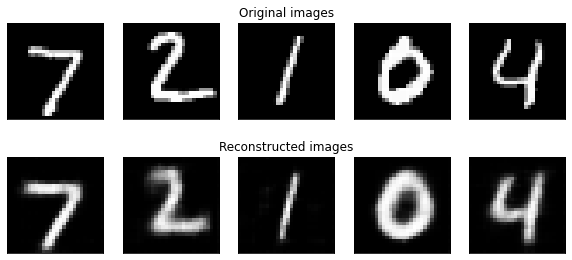

	 partial train loss (single batch): 8334.138672
	 partial train loss (single batch): 8484.518555
	 partial train loss (single batch): 8262.601562
	 partial train loss (single batch): 8441.883789
	 partial train loss (single batch): 7883.193359
	 partial train loss (single batch): 8127.257324
	 partial train loss (single batch): 7885.532227
	 partial train loss (single batch): 7960.472656
	 partial train loss (single batch): 8250.348633
	 partial train loss (single batch): 8057.011719
	 partial train loss (single batch): 8031.905762
	 partial train loss (single batch): 8264.787109
	 partial train loss (single batch): 8218.739258
	 partial train loss (single batch): 8154.817383
	 partial train loss (single batch): 8271.468750
	 partial train loss (single batch): 8217.393555
	 partial train loss (single batch): 8183.067871
	 partial train loss (single batch): 8455.826172
	 partial train loss (single batch): 7931.405273
	 partial train loss (single batch): 8211.759766
	 partial train loss

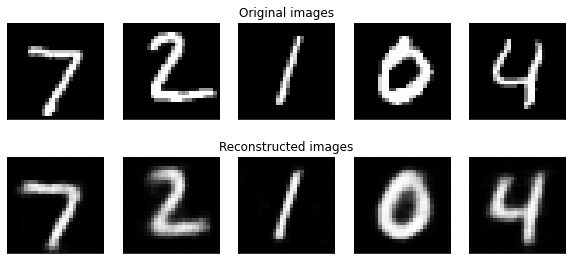

	 partial train loss (single batch): 8278.953125
	 partial train loss (single batch): 8501.613281
	 partial train loss (single batch): 8255.021484
	 partial train loss (single batch): 8437.519531
	 partial train loss (single batch): 7875.635254
	 partial train loss (single batch): 8059.653809
	 partial train loss (single batch): 7909.817383
	 partial train loss (single batch): 7994.168945
	 partial train loss (single batch): 8190.961914
	 partial train loss (single batch): 8098.390137
	 partial train loss (single batch): 8148.633789
	 partial train loss (single batch): 8315.253906
	 partial train loss (single batch): 8222.393555
	 partial train loss (single batch): 8154.841797
	 partial train loss (single batch): 8112.009766
	 partial train loss (single batch): 8148.403320
	 partial train loss (single batch): 8145.347656
	 partial train loss (single batch): 8353.083984
	 partial train loss (single batch): 7933.034180
	 partial train loss (single batch): 8145.193848
	 partial train loss

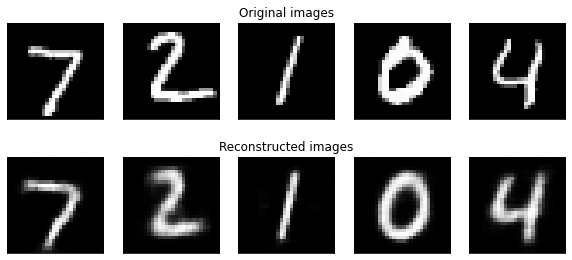

	 partial train loss (single batch): 8181.698242
	 partial train loss (single batch): 8413.384766
	 partial train loss (single batch): 8237.734375
	 partial train loss (single batch): 8507.445312
	 partial train loss (single batch): 7842.078613
	 partial train loss (single batch): 8116.600586
	 partial train loss (single batch): 7955.182129
	 partial train loss (single batch): 8014.576172
	 partial train loss (single batch): 8215.289062
	 partial train loss (single batch): 8059.567383
	 partial train loss (single batch): 8087.998047
	 partial train loss (single batch): 8321.713867
	 partial train loss (single batch): 8148.034180
	 partial train loss (single batch): 8106.473145
	 partial train loss (single batch): 8097.936523
	 partial train loss (single batch): 8157.959961
	 partial train loss (single batch): 8100.303711
	 partial train loss (single batch): 8394.339844
	 partial train loss (single batch): 7830.376953
	 partial train loss (single batch): 8048.039062
	 partial train loss

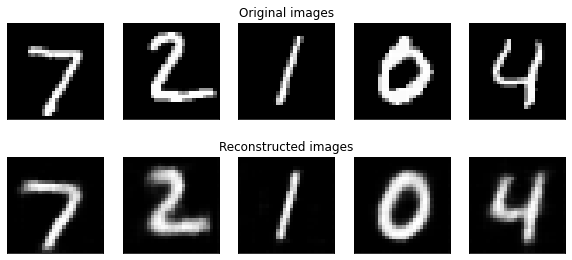

In [25]:
num_epochs = 50
history_vae={'train_loss':[],'val_loss':[]}

for epoch in range(num_epochs):

    train_loss = train_epoch(vae,device,train_loader,optim)
    val_loss = test_epoch(vae,device,valid_loader)
    history_vae['train_loss'].append(train_loss)
    history_vae['val_loss'].append(val_loss)
    print('\n EPOCH {}/{} \t train loss {:.3f} \t val loss {:.3f}'.format(epoch + 1, num_epochs,train_loss,val_loss))

    plot_ae_outputs(vae.encoder,vae.decoder,n=5)

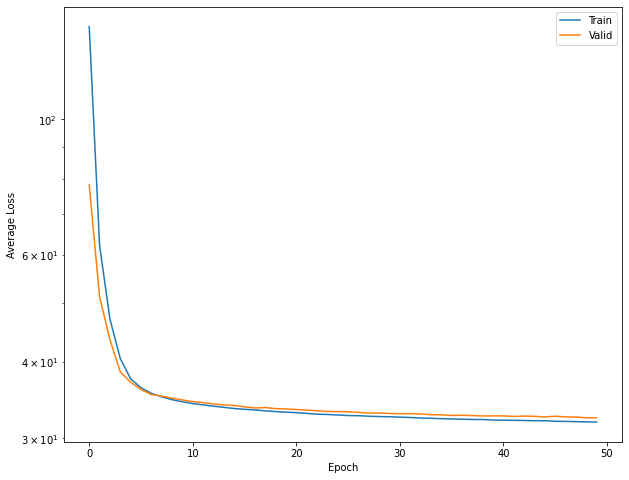

In [26]:
# Plot training performance
test_epoch(vae,device,test_loader)
plt.figure(figsize=(10,8))
plt.semilogy(history_vae['train_loss'], label='Train')
plt.semilogy(history_vae['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.legend()
plt.show()

## 4.Visualize latent space

100%|██████████| 10000/10000 [00:03<00:00, 2500.25it/s]


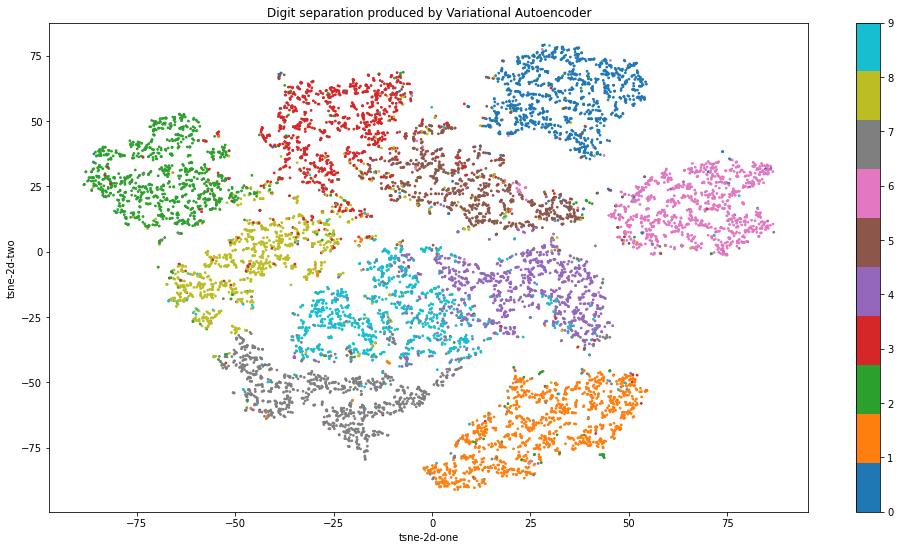

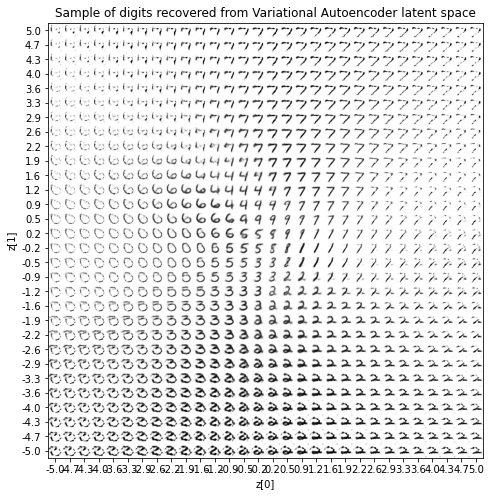

In [27]:
def plot_results(model, data, rx=(-5, 5), ry=(-5, 5), model_name='VAE'):

    # Encode all data samples
    encoded_samples = []
    for sample in tqdm(data):
        
        # Separate image data from its label 
        img = sample[0].unsqueeze(0).to(device)
        label = sample[1]
        
        # Encode image
        vae.eval()
        with torch.no_grad():
            encoded_img  = model.encoder(img)
        
        # Append to list
        encoded_img = encoded_img.flatten().cpu().numpy()
        encoded_sample = {f"Enc. Variable {i}": enc for i, enc in enumerate(encoded_img)}
        encoded_sample['label'] = label
        encoded_samples.append(encoded_sample)
        
        # Find latend dimension from decoded image
        latent_dim = len(encoded_img)
        
    encoded_samples = pd.DataFrame(encoded_samples)

    # Create a TSNE model and plot it
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(encoded_samples.drop(['label'],axis=1))
    
    plt.figure(figsize=(17, 9))
    plt.scatter(tsne_results[:,0], tsne_results[:,1], c=encoded_samples.label, cmap='tab10', s=3)
    plt.xlabel('tsne-2d-one')
    plt.ylabel('tsne-2d-two')
    plt.title(f'Digit separation produced by {model_name}')
    plt.colorbar()
    plt.show()
    
    # Prepare a n x n 2D matrix of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    
    # Create a linearly spaced coordinates of 2D digit classes in latent space
    grid_x = np.linspace(*rx, n)
    grid_y = np.linspace(*ry, n)[::-1]

    # Populate the matrix with images decoded from latent space
    for i, yi in enumerate(grid_y):
        for j, xj in enumerate(grid_x):
            # coords = [xj, yi, 0, 0] # Use latent_dim
            coords = list(np.zeros(latent_dim))
            coords[0] = xj
            coords[1] = yi
            z = torch.Tensor([coords]).to(device)
            x_hat = model.decoder(z)
            digit = x_hat.reshape(digit_size, digit_size).to('cpu').detach().numpy()
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    # Plot the matrix of "fake" sample digits
    plt.figure(figsize=(8, 8))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.title(f'Sample of digits recovered from {model_name} latent space')
    plt.imshow(figure, cmap='Greys')
    # plt.savefig(filename)
    plt.show()

plot_results(vae, test_dataset, rx=(-5, 5), ry=(-5, 5), model_name="Variational Autoencoder")

In [28]:
import qiskit.tools.jupyter
%qiskit_version_table